In [263]:
FILE_NAME = 'magazine_dataset.csv'

import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import math

from sklearn.preprocessing import MinMaxScaler

print(tf.__version__)

2.0.0


In [264]:
def plot_series(time, series, lab, form='-', start=0, end=None):
    plt.plot(time[start:end], series[start:end], form, label=lab)
    plt.xlabel("Minuto")
    plt.ylabel("Preço")
    plt.grid(True)
    
def split_dataset(dataset):
    size = dataset.shape[0]
    train_size = size * 80 // 100
    test_size = (size - train_size) // 2
    
    return dataset[0:train_size, :], dataset[train_size:(train_size + test_size), :], dataset[(train_size + test_size):size, :]

def tf_dataset(series_x, series_y, batch_size, shuffle_buffer, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((series_x, series_y))
    if shuffle:
        ds = ds.cache().shuffle(shuffle_buffer).batch(batch_size).repeat()
    else:
        ds = ds.cache().batch(batch_size).repeat()

    return ds

def create_window_dataset(ds, lb, window_size):
    windowed_dataset = []
    labels = []
    
    for i in range(WINDOW_SIZE, ds.shape[0], WINDOW_SIZE):
        windowed_dataset.append(ds[i - WINDOW_SIZE:i])
        labels.append(lb[i - 1])
    
    return np.array(windowed_dataset), np.array(labels)

In [265]:
data = pd.read_csv(FILE_NAME, sep=',')
data = data[['open', 'high', 'low', 'close', 'dollar_close', 'volume', 'sentiment_polarity', 'close']]
data.columns.values[7] = "y"
data.head()

,open,high,low,close,dollar_close,volume,sentiment_polarity,y
0,33.0013,33.0316,32.7213,32.8513,4.1007,0,0.06801,32.8513
1,32.8810,33.1225,32.8522,33.0411,4.0994,301337,0.06801,33.0411
2,33.0200,33.3100,33.0200,33.1300,4.0979,177100,0.06801,33.1300
3,33.1506,33.1761,32.9759,33.0006,4.0971,179428,0.06801,33.0006
4,33.0012,33.1010,32.9008,32.9112,4.0974,204443,0.06801,32.9112


In [266]:
dataset = data['y']
dataset.loc[dataset.shape[0]]= 0.0
dataset = dataset.iloc[1:]
data.iloc[:, -1] = dataset.values
dataset = data[:-1]

dataset_to_numpy = dataset.values
dataset.head()

,open,high,low,close,dollar_close,volume,sentiment_polarity,y
0,33.0013,33.0316,32.7213,32.8513,4.1007,0,0.06801,33.0411
1,32.8810,33.1225,32.8522,33.0411,4.0994,301337,0.06801,33.1300
2,33.0200,33.3100,33.0200,33.1300,4.0979,177100,0.06801,33.0006
3,33.1506,33.1761,32.9759,33.0006,4.0971,179428,0.06801,32.9112
4,33.0012,33.1010,32.9008,32.9112,4.0974,204443,0.06801,32.8800


# Split dataset

In [267]:
train_dataset, cross_validation_dataset, dev_dataset = split_dataset(dataset_to_numpy)

print("Dataset shape: {:s}".format(str(dataset_to_numpy.shape)))
print("Train dataset shape: {:s}".format(str(train_dataset.shape)))
print("Cross validation dataset shape: {:s}".format(str(cross_validation_dataset.shape)))
print("Dev dataset shape: {:s}".format(str(dev_dataset.shape)))

Dataset shape: (11796, 8)
Train dataset shape: (9436, 8)
Cross validation dataset shape: (1180, 8)
Dev dataset shape: (1180, 8)


# Stock prices graph

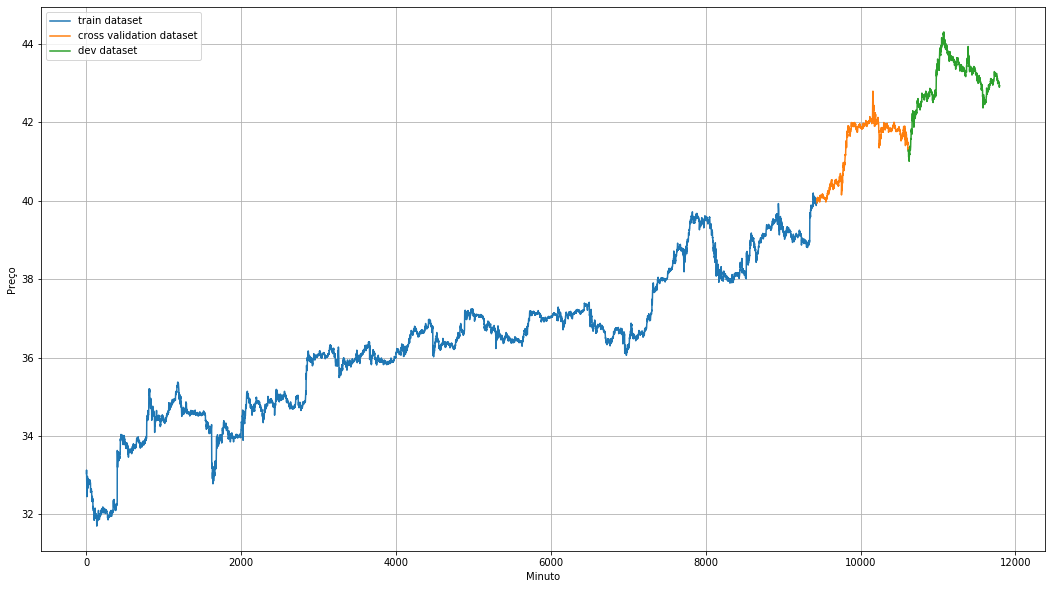

In [268]:
plt.figure(figsize=(18, 10))
plot_series(np.arange(train_dataset.shape[0]), train_dataset[:, -1], "train dataset")
plot_series(np.arange(train_dataset.shape[0], (cross_validation_dataset.shape[0] + train_dataset.shape[0])), cross_validation_dataset[:, -1], "cross validation dataset")
plot_series(np.arange((cross_validation_dataset.shape[0] + train_dataset.shape[0]), (cross_validation_dataset.shape[0]+ train_dataset.shape[0] + dev_dataset.shape[0])), dev_dataset[:, -1], "dev dataset")
plt.legend(loc='upper left')

# Data normalization

In [269]:
scaler = MinMaxScaler()
scaler = scaler.fit(train_dataset[:, 0:-1])

train_dataset_normalized = scaler.transform(train_dataset[:, 0:-1])
cross_validation_dataset_normalized = scaler.transform(cross_validation_dataset[:, 0:-1])
dev_dataset_normalized = scaler.transform(dev_dataset[:, 0:-1])

# Create window dataset

In [303]:
WINDOW_SIZE = 1
BATCH_SIZE = 100

windowed_dataset_train, labels_train = create_window_dataset(train_dataset_normalized, train_dataset[:, -1], WINDOW_SIZE)
train_set = tf_dataset(windowed_dataset_train, labels_train, BATCH_SIZE, 1000)
unshuffled_train_set = tf_dataset(windowed_dataset_train, labels_train, BATCH_SIZE, 1000, False)

windowed_dataset_validation, labels_validation = create_window_dataset(cross_validation_dataset_normalized, cross_validation_dataset[:, -1], WINDOW_SIZE)
cross_validation_set = tf_dataset(windowed_dataset_validation, labels_validation, BATCH_SIZE, 1000)
unshuffled_cross_validation_set = tf_dataset(windowed_dataset_validation, labels_validation, BATCH_SIZE, 1000, False)

# for dev set the batch size needs to fit the data
# https://stackoverflow.com/questions/54159034/what-if-the-sample-size-is-not-divisible-by-batch-size-in-keras-model
windowed_dataset_dev, labels_dev = create_window_dataset(dev_dataset_normalized, dev_dataset[:, -1], WINDOW_SIZE)
for i in range(1,160):
    if windowed_dataset_dev.shape[0] % i == 0:
        dev_batch = i
dev_set = tf_dataset(windowed_dataset_dev, labels_dev, dev_batch, 1000, False)

# Train model

In [304]:
TRAIN_STEP = math.ceil(windowed_dataset_train.shape[0] / BATCH_SIZE)
VALIDATION_STEP = math.ceil(windowed_dataset_validation.shape[0] / BATCH_SIZE)
DEV_STEP = windowed_dataset_dev.shape[0] / dev_batch

In [271]:
tf.keras.backend.clear_session()
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=64,
                           kernel_size=5,
                           strides=1,
                           padding="causal",
                           activation="relu",
                           input_shape=windowed_dataset_train.shape[-2:]),
    tf.keras.layers.MaxPooling1D(pool_size=2, strides=1, padding="same"),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
#     tf.keras.layers.Lambda(lambda x: x * 100)
])

model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9), metrics=['mae'])
history = model.fit(train_set,
                    epochs=500,
                    steps_per_epoch=TRAIN_STEP,
                    validation_data=cross_validation_set,
                    validation_steps=VALIDATION_STEP)

Train for 95 steps, validate for 12 steps
Epoch 1/250
95/95 [==============================] - 5s 52ms/step - loss: 1276.0974 - mae: 35.6865 - val_loss: 1575.3679 - val_mae: 39.6840
Epoch 2/250
95/95 [==============================] - 1s 10ms/step - loss: 975.1751 - mae: 31.2069 - val_loss: 778.4363 - val_mae: 27.8901
Epoch 3/250
95/95 [==============================] - 1s 10ms/step - loss: 82.9419 - mae: 6.4275 - val_loss: 8.3822 - val_mae: 2.8046
Epoch 4/250
95/95 [==============================] - 1s 10ms/step - loss: 4.0556 - mae: 1.5897 - val_loss: 9.1425 - val_mae: 2.9415
Epoch 5/250
95/95 [==============================] - 1s 10ms/step - loss: 4.0112 - mae: 1.5843 - val_loss: 9.1369 - val_mae: 2.9397
Epoch 6/250
95/95 [==============================] - 1s 10ms/step - loss: 3.9879 - mae: 1.5779 - val_loss: 9.0931 - val_mae: 2.9291
Epoch 7/250
95/95 [==============================] - 1s 10ms/step - loss: 3.9990 - mae: 1.5805 - val_loss: 9.0717 - val_mae: 2.9288
Epoch 8/250
95/95 [

95/95 [==============================] - 1s 10ms/step - loss: 2.8152 - mae: 1.3127 - val_loss: 6.3994 - val_mae: 2.4581
Epoch 63/250
95/95 [==============================] - 1s 10ms/step - loss: 2.7639 - mae: 1.3003 - val_loss: 6.3061 - val_mae: 2.4384
Epoch 64/250
95/95 [==============================] - 1s 10ms/step - loss: 2.7227 - mae: 1.2931 - val_loss: 6.1952 - val_mae: 2.4198
Epoch 65/250
95/95 [==============================] - 1s 10ms/step - loss: 2.6592 - mae: 1.2750 - val_loss: 6.1033 - val_mae: 2.4008
Epoch 66/250
95/95 [==============================] - 1s 10ms/step - loss: 2.6217 - mae: 1.2639 - val_loss: 5.9852 - val_mae: 2.3786
Epoch 67/250
95/95 [==============================] - 1s 10ms/step - loss: 2.5604 - mae: 1.2512 - val_loss: 5.9275 - val_mae: 2.3666
Epoch 68/250
95/95 [==============================] - 1s 10ms/step - loss: 2.5008 - mae: 1.2330 - val_loss: 5.7836 - val_mae: 2.3378
Epoch 69/250
95/95 [==============================] - 1s 10ms/step - loss: 2.4594 

KeyboardInterrupt: 

## Save model weights

In [222]:
model.save_weights('weights/model_weights.ckpt')

## Load Saved model weights

In [282]:
model.load_weights('weights/model_weights.ckpt')

# Predictions: Train data

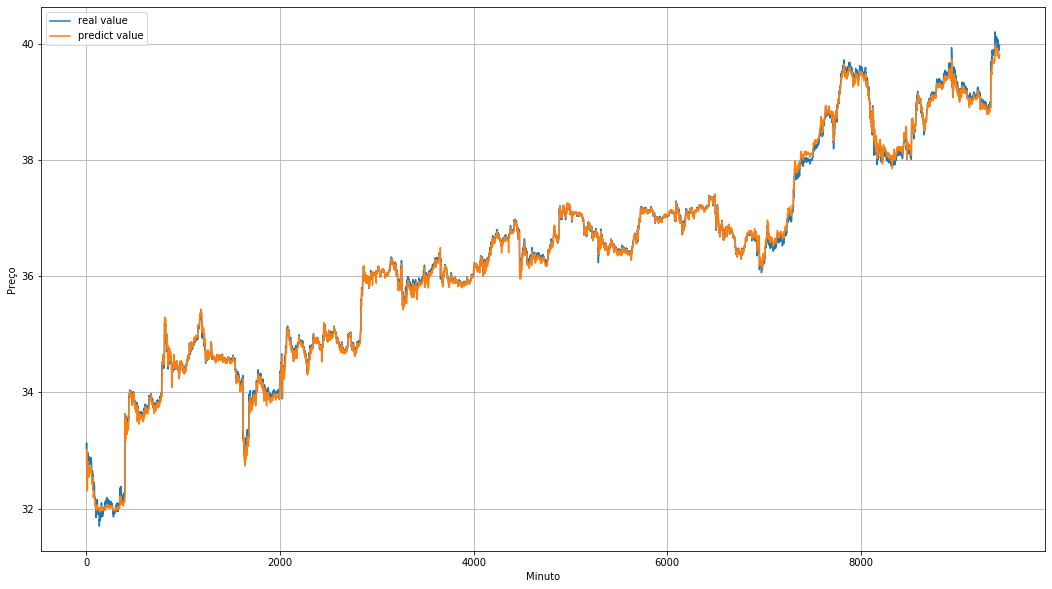

In [291]:
forecast_train = model.predict(unshuffled_train_set, steps=TRAIN_STEP)

plt.figure(figsize=(18, 10))
plot_series(np.arange(labels_train.shape[0]), labels_train, "real value")
plot_series(np.arange(labels_train.shape[0]), forecast_train[:,0,0], "predict value")
plt.legend(loc='upper left')

# Predictions: Validation data

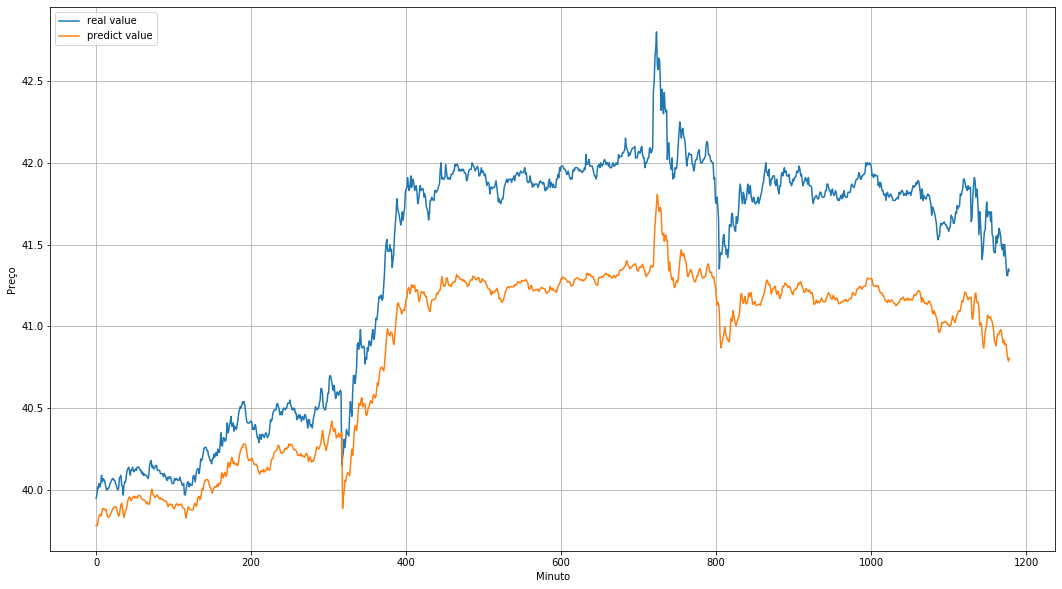

In [295]:
forecast_validation = model.predict(unshuffled_cross_validation_set, steps=VALIDATION_STEP)

plt.figure(figsize=(18, 10))
plot_series(np.arange(labels_validation.shape[0]), labels_validation, "real value")
plot_series(np.arange(labels_validation.shape[0]), forecast_validation[:,0,0], "predict value")
plt.legend(loc='upper left')

# Predictions: Dev data

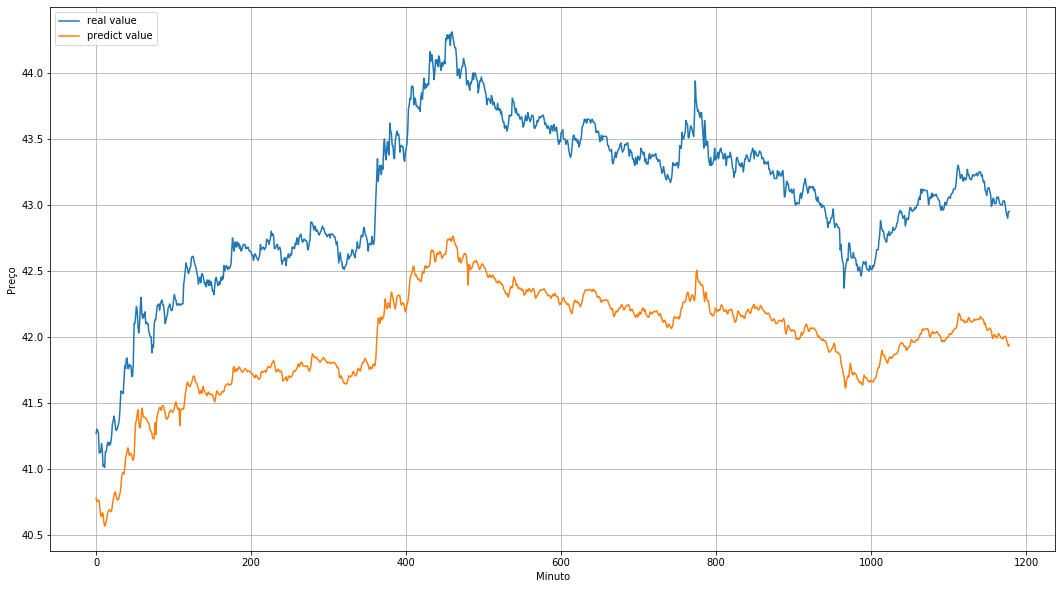

In [306]:
forecast_dev = model.predict(dev_set, steps=DEV_STEP)

plt.figure(figsize=(18, 10))
plot_series(np.arange(labels_dev.shape[0]), labels_dev, "real value")
plot_series(np.arange(labels_dev.shape[0]), forecast_dev[:,0,0], "predict value")
plt.legend(loc='upper left')